In [65]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import pandas as pd
import keras
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn import preprocessing
from keras.utils import np_utils
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv("../data/titanic/train.csv")
test = pd.read_csv("../data/titanic/test.csv")
train = train.append(test) ## test 데이터도 학습에 이용.

# inplace=True 로 해야 모든 컬럼에 대해 fillna 가 이뤄짐.
# train.fillna(0, inplace=True) 
# test.fillna(0, inplace=True)


print(train.shape)
print(test.shape)

train



(1309, 12)
(418, 11)


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


In [66]:

# cols = PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked

# 데이터 전처리 : 학습에 필요없는 column 제거.
train.pop('Name'), test.pop('Name')
train.pop('Ticket'), test.pop('Ticket')
train.pop('Cabin'), test.pop('Cabin')
train.pop('PassengerId'), test.pop('PassengerId') # 제거하지 않으면 passengerId 가 높을수록 predicton value 가 높은 현상

# train 은 Nan data 제거하고, test 는 row 수를 유지하기 위해 drop 대신 fill.
train.dropna(inplace=True)
test.fillna(0, inplace=True)
print(train.shape)
print(test.shape)

# 데이터 전처리 : One Hot Encoding
# 성별, 승선지 는 String data. -> labelBinarizer를 이용해서 자동으로 one-hot-encoding
# 컬럼의 data 종류 학습.
# one-hot-encode 형태의 컬럼 추가.
# 구 컬럼 삭제 ( DataFrame.pop() )
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
enc = encoder.fit(train[['Embarked']].astype(str))
train = pd.merge(train, pd.DataFrame(enc.transform(train[['Embarked']].astype(str))) , right_index=True, left_index=True)
test = pd.merge(test, pd.DataFrame(enc.transform(test[['Embarked']].astype(str))) , right_index=True, left_index=True)
enc = encoder.fit(train[['Sex']].astype(str))
train = pd.merge(train, pd.DataFrame(enc.transform(train[['Sex']].astype(str))) , right_index=True, left_index=True)
test = pd.merge(test, pd.DataFrame(enc.transform(test[['Sex']].astype(str))) , right_index=True, left_index=True)
train.pop('Embarked'), test.pop('Embarked')
train.pop('Sex'), test.pop('Sex')

# label
y_train = train[['Survived']]

# feature
train.pop('Survived')
x_train = train
x_test = test

x_train.head(5)



(712, 8)
(418, 7)


,Age,Fare,Parch,Pclass,SibSp,0_x,1,2,0_y
0,22.0,7.2500,0,3,1,0,0,1,1
1,38.0,71.2833,0,1,1,1,0,0,0
2,26.0,7.9250,0,3,0,0,0,1,0
3,35.0,53.1000,0,1,1,0,0,1,0
4,35.0,8.0500,0,3,0,0,0,1,1


In [67]:
# #### outlier detection #####
# from sklearn.cluster import DBSCAN
# outlier_detection = DBSCAN(
#     eps = 50,
#     metric="euclidean",
#     n_jobs = -1)
# clusters = outlier_detection.fit_predict(train[['Fare']])
# clusters

In [68]:
# mixmax scaler, normalizer 등의 전처리 아직 없음.

(array([264.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 182.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

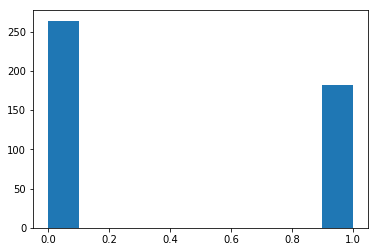

In [69]:
# 대강의 label 분포 보기
plt.hist(y_train['Survived'])

In [70]:
x_test.head(5)

,Pclass,Age,SibSp,Parch,Fare,0_x,1,2,0_y
0,3,34.5,0,0,7.8292,0,1,0,1
1,3,47.0,1,0,7.0000,0,0,1,0
2,2,62.0,0,0,9.6875,0,1,0,1
3,3,27.0,0,0,8.6625,0,0,1,1
4,3,22.0,1,1,12.2875,0,0,1,0


In [83]:

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=len(x_train.columns)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5)) # 과적합방지 Dropout. 
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# opt = optimizers.Adam(lr=0.001, beta_1=0.5, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
opt = optimizers.Adam(lr=0.01, decay=0.1, amsgrad=True)

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print(model.summary)

hist = model.fit(x_train, y_train, epochs=500, batch_size=50,validation_split=0.1)

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x1a2c9c8320>>
Train on 401 samples, validate on 45 samples
Epoch 1/500
401/401 [==============================] - 1s 3ms/step - loss: 0.7457 - acc: 0.5536 - val_loss: 0.6928 - val_acc: 0.4667
Epoch 2/500
401/401 [==============================] - 0s 89us/step - loss: 0.6675 - acc: 0.6284 - val_loss: 0.6763 - val_acc: 0.4667
Epoch 3/500
401/401 [==============================] - 0s 78us/step - loss: 0.6713 - acc: 0.6010 - val_loss: 0.6939 - val_acc: 0.4667
Epoch 4/500
401/401 [==============================] - 0s 65us/step - loss: 0.6618 - acc: 0.6334 - val_loss: 0.6912 - val_acc: 0.6000
Epoch 5/500
401/401 [==============================] - 0s 54us/step - loss: 0.6717 - acc: 0.6135 - val_loss: 0.6934 - val_acc: 0.4889
Epoch 6/500
401/401 [==============================] - 0s 66us/step - loss: 0.6962 - acc: 0.6010 - val_loss: 0.6931 - val_acc: 0.4889
Epoch 7/500
401/401 [==============================] - 0s 

Epoch 61/500
401/401 [==============================] - 0s 57us/step - loss: 0.6355 - acc: 0.6284 - val_loss: 0.6652 - val_acc: 0.6222
Epoch 62/500
401/401 [==============================] - 0s 82us/step - loss: 0.6297 - acc: 0.6608 - val_loss: 0.6622 - val_acc: 0.6444
Epoch 63/500
401/401 [==============================] - 0s 55us/step - loss: 0.6393 - acc: 0.6633 - val_loss: 0.6686 - val_acc: 0.6222
Epoch 64/500
401/401 [==============================] - 0s 55us/step - loss: 0.6355 - acc: 0.6409 - val_loss: 0.6751 - val_acc: 0.6667
Epoch 65/500
401/401 [==============================] - 0s 51us/step - loss: 0.6360 - acc: 0.6608 - val_loss: 0.6811 - val_acc: 0.6222
Epoch 66/500
401/401 [==============================] - 0s 52us/step - loss: 0.6347 - acc: 0.6708 - val_loss: 0.6590 - val_acc: 0.6667
Epoch 67/500
401/401 [==============================] - 0s 52us/step - loss: 0.6391 - acc: 0.6509 - val_loss: 0.6589 - val_acc: 0.6444
Epoch 68/500
401/401 [==============================] -

401/401 [==============================] - 0s 74us/step - loss: 0.6166 - acc: 0.6933 - val_loss: 0.6657 - val_acc: 0.6889
Epoch 122/500
401/401 [==============================] - 0s 71us/step - loss: 0.6065 - acc: 0.6858 - val_loss: 0.6808 - val_acc: 0.6667
Epoch 123/500
401/401 [==============================] - 0s 65us/step - loss: 0.6121 - acc: 0.6858 - val_loss: 0.6636 - val_acc: 0.6444
Epoch 124/500
401/401 [==============================] - 0s 57us/step - loss: 0.6071 - acc: 0.6808 - val_loss: 0.6376 - val_acc: 0.7111
Epoch 125/500
401/401 [==============================] - 0s 60us/step - loss: 0.6110 - acc: 0.6883 - val_loss: 0.6420 - val_acc: 0.6889
Epoch 126/500
401/401 [==============================] - 0s 71us/step - loss: 0.6180 - acc: 0.6833 - val_loss: 0.6303 - val_acc: 0.7111
Epoch 127/500
401/401 [==============================] - 0s 67us/step - loss: 0.6097 - acc: 0.6808 - val_loss: 0.6529 - val_acc: 0.6222
Epoch 128/500
401/401 [==============================] - 0s 55

401/401 [==============================] - 0s 51us/step - loss: 0.5921 - acc: 0.6958 - val_loss: 0.6124 - val_acc: 0.7111
Epoch 182/500
401/401 [==============================] - 0s 51us/step - loss: 0.5834 - acc: 0.6908 - val_loss: 0.6079 - val_acc: 0.6889
Epoch 183/500
401/401 [==============================] - 0s 54us/step - loss: 0.5968 - acc: 0.6983 - val_loss: 0.6275 - val_acc: 0.6889
Epoch 184/500
401/401 [==============================] - 0s 56us/step - loss: 0.5836 - acc: 0.7032 - val_loss: 0.6216 - val_acc: 0.6889
Epoch 185/500
401/401 [==============================] - 0s 54us/step - loss: 0.5817 - acc: 0.7032 - val_loss: 0.6606 - val_acc: 0.6889
Epoch 186/500
401/401 [==============================] - 0s 58us/step - loss: 0.6101 - acc: 0.7032 - val_loss: 0.6435 - val_acc: 0.6667
Epoch 187/500
401/401 [==============================] - 0s 56us/step - loss: 0.5825 - acc: 0.7057 - val_loss: 0.6401 - val_acc: 0.6889
Epoch 188/500
401/401 [==============================] - 0s 51

401/401 [==============================] - 0s 57us/step - loss: 0.5884 - acc: 0.6983 - val_loss: 0.5948 - val_acc: 0.6889
Epoch 242/500
401/401 [==============================] - 0s 57us/step - loss: 0.5581 - acc: 0.7182 - val_loss: 0.6068 - val_acc: 0.6889
Epoch 243/500
401/401 [==============================] - 0s 50us/step - loss: 0.5753 - acc: 0.7082 - val_loss: 0.6198 - val_acc: 0.6667
Epoch 244/500
401/401 [==============================] - 0s 57us/step - loss: 0.5826 - acc: 0.6908 - val_loss: 0.5927 - val_acc: 0.6889
Epoch 245/500
401/401 [==============================] - 0s 52us/step - loss: 0.5701 - acc: 0.7057 - val_loss: 0.5890 - val_acc: 0.6889
Epoch 246/500
401/401 [==============================] - 0s 48us/step - loss: 0.5906 - acc: 0.7032 - val_loss: 0.6029 - val_acc: 0.6889
Epoch 247/500
401/401 [==============================] - 0s 65us/step - loss: 0.5863 - acc: 0.6908 - val_loss: 0.5939 - val_acc: 0.6889
Epoch 248/500
401/401 [==============================] - 0s 55

401/401 [==============================] - 0s 49us/step - loss: 0.5628 - acc: 0.7132 - val_loss: 0.5917 - val_acc: 0.6889
Epoch 302/500
401/401 [==============================] - 0s 51us/step - loss: 0.5374 - acc: 0.7282 - val_loss: 0.5919 - val_acc: 0.6889
Epoch 303/500
401/401 [==============================] - 0s 48us/step - loss: 0.5533 - acc: 0.7157 - val_loss: 0.6218 - val_acc: 0.6889
Epoch 304/500
401/401 [==============================] - 0s 53us/step - loss: 0.5407 - acc: 0.7332 - val_loss: 0.6064 - val_acc: 0.6667
Epoch 305/500
401/401 [==============================] - 0s 51us/step - loss: 0.5589 - acc: 0.7132 - val_loss: 0.6485 - val_acc: 0.6222
Epoch 306/500
401/401 [==============================] - 0s 55us/step - loss: 0.5587 - acc: 0.7082 - val_loss: 0.6219 - val_acc: 0.6444
Epoch 307/500
401/401 [==============================] - 0s 52us/step - loss: 0.5516 - acc: 0.7132 - val_loss: 0.6294 - val_acc: 0.6667
Epoch 308/500
401/401 [==============================] - 0s 55

401/401 [==============================] - 0s 50us/step - loss: 0.5556 - acc: 0.7406 - val_loss: 0.5792 - val_acc: 0.6889
Epoch 362/500
401/401 [==============================] - 0s 51us/step - loss: 0.5325 - acc: 0.7257 - val_loss: 0.6357 - val_acc: 0.6667
Epoch 363/500
401/401 [==============================] - 0s 52us/step - loss: 0.5662 - acc: 0.7157 - val_loss: 0.6150 - val_acc: 0.6889
Epoch 364/500
401/401 [==============================] - 0s 53us/step - loss: 0.5366 - acc: 0.7431 - val_loss: 0.5953 - val_acc: 0.6889
Epoch 365/500
401/401 [==============================] - 0s 53us/step - loss: 0.5485 - acc: 0.7007 - val_loss: 0.6063 - val_acc: 0.6889
Epoch 366/500
401/401 [==============================] - 0s 54us/step - loss: 0.5259 - acc: 0.7357 - val_loss: 0.6339 - val_acc: 0.6667
Epoch 367/500
401/401 [==============================] - 0s 56us/step - loss: 0.5715 - acc: 0.7132 - val_loss: 0.6164 - val_acc: 0.6444
Epoch 368/500
401/401 [==============================] - 0s 54

401/401 [==============================] - 0s 62us/step - loss: 0.5318 - acc: 0.7157 - val_loss: 0.6100 - val_acc: 0.6889
Epoch 422/500
401/401 [==============================] - 0s 57us/step - loss: 0.5252 - acc: 0.7382 - val_loss: 0.5954 - val_acc: 0.7111
Epoch 423/500
401/401 [==============================] - 0s 60us/step - loss: 0.5242 - acc: 0.7357 - val_loss: 0.6201 - val_acc: 0.7111
Epoch 424/500
401/401 [==============================] - 0s 57us/step - loss: 0.5219 - acc: 0.7506 - val_loss: 0.5711 - val_acc: 0.7333
Epoch 425/500
401/401 [==============================] - 0s 55us/step - loss: 0.5337 - acc: 0.7207 - val_loss: 0.5799 - val_acc: 0.7111
Epoch 426/500
401/401 [==============================] - 0s 59us/step - loss: 0.5178 - acc: 0.7357 - val_loss: 0.6178 - val_acc: 0.6444
Epoch 427/500
401/401 [==============================] - 0s 60us/step - loss: 0.5355 - acc: 0.7257 - val_loss: 0.5596 - val_acc: 0.6889
Epoch 428/500
401/401 [==============================] - 0s 61

401/401 [==============================] - 0s 52us/step - loss: 0.5171 - acc: 0.7357 - val_loss: 0.5828 - val_acc: 0.7111
Epoch 482/500
401/401 [==============================] - 0s 52us/step - loss: 0.5226 - acc: 0.7107 - val_loss: 0.6258 - val_acc: 0.7111
Epoch 483/500
401/401 [==============================] - 0s 55us/step - loss: 0.5001 - acc: 0.7481 - val_loss: 0.6026 - val_acc: 0.6889
Epoch 484/500
401/401 [==============================] - 0s 56us/step - loss: 0.5279 - acc: 0.7207 - val_loss: 0.6236 - val_acc: 0.6889
Epoch 485/500
401/401 [==============================] - 0s 53us/step - loss: 0.5144 - acc: 0.7357 - val_loss: 0.6513 - val_acc: 0.6444
Epoch 486/500
401/401 [==============================] - 0s 52us/step - loss: 0.5167 - acc: 0.7556 - val_loss: 0.6245 - val_acc: 0.6889
Epoch 487/500
401/401 [==============================] - 0s 52us/step - loss: 0.5018 - acc: 0.7531 - val_loss: 0.6773 - val_acc: 0.6444
Epoch 488/500
401/401 [==============================] - 0s 59

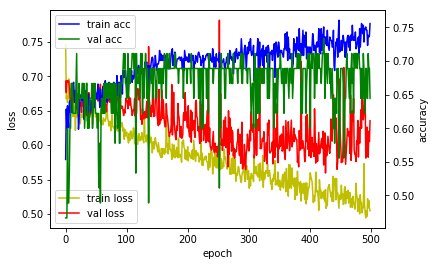

In [84]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower left')
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [85]:
model.predict(x_test)

array([[5.12629887e-03],
       [3.00681964e-02],
       [3.26618855e-03],
       [3.27836303e-03],
       [3.87754757e-04],
       [1.16030974e-02],
       [5.52363321e-03],
       [5.69260408e-07],
       [2.43313983e-03],
       [1.48936579e-05],
       [3.73905718e-01],
       [1.49321586e-08],
       [1.46281980e-14],
       [5.81628257e-09],
       [1.88490106e-14],
       [3.30268705e-07],
       [1.24530517e-04],
       [2.50709988e-03],
       [6.90216757e-03],
       [4.96190833e-03],
       [5.98717319e-15],
       [3.51989836e-01],
       [8.27715412e-05],
       [2.10040145e-11],
       [0.00000000e+00],
       [5.50160403e-05],
       [6.77690412e-12],
       [2.60649528e-03],
       [6.90295021e-09],
       [4.13595885e-03],
       [1.15620740e-08],
       [4.58039608e-07],
       [1.47594255e-06],
       [3.66100646e-03],
       [3.84443952e-12],
       [2.75851297e-03],
       [1.54550448e-01],
       [2.98247579e-03],
       [1.64196186e-03],
       [6.17292599e-08],


(array([407.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  11.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

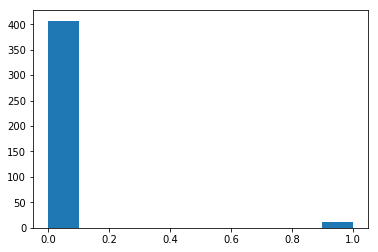

In [86]:
pred = model.predict_classes(x_test)
# live = len([x for x in pred.ravel() if x==1])
# death = len([x for x in pred.ravel() if x==0])
# print("live : " , live)
# print("death : " , death)
# print("생존율 : ", live / (live + death))
# pred

plt.hist(pred)

In [87]:
df_pred = pd.read_csv("../data/titanic/gender_submission.csv")
df_pred[['Survived']] = pred
# df_pred

In [88]:
df_pred.to_csv('result.csv', index=False)